# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [7]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.367536
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [19]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.353709 analytic: 1.353709, relative error: 3.660349e-08
numerical: -0.695986 analytic: -0.695986, relative error: 8.141200e-09
numerical: 0.013173 analytic: 0.013173, relative error: 8.851098e-07
numerical: 0.125222 analytic: 0.125222, relative error: 5.363990e-07
numerical: -0.287079 analytic: -0.287079, relative error: 1.418507e-07
numerical: 1.439701 analytic: 1.439701, relative error: 1.909073e-08
numerical: 1.932238 analytic: 1.932238, relative error: 3.333738e-10
numerical: -2.527815 analytic: -2.527815, relative error: 3.139412e-11
numerical: 2.610955 analytic: 2.610955, relative error: 6.740767e-09
numerical: -0.041329 analytic: -0.041329, relative error: 1.117454e-06
numerical: -1.270021 analytic: -1.270021, relative error: 8.247766e-09
numerical: 6.346588 analytic: 6.346588, relative error: 4.125616e-09
numerical: 1.172836 analytic: 1.172836, relative error: 2.584603e-08
numerical: 1.140045 analytic: 1.140044, relative error: 9.543384e-09
numerical: -1.054973 ana

In [26]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.367536e+00 computed in 0.101727s
[1.02592674 0.76682531 1.21424048 1.36647502 1.43425461 0.63309039
 0.95981558 0.91308691 1.1086843  1.11474473 1.95656144 0.92944158
 1.28908386 1.16348456 1.04788942 0.59692372 0.97792026 0.48827952
 1.21888567 0.70964763 0.70070213 0.96135226 0.61574147 0.94089231
 1.37692388 1.03679991 0.65880601 0.86451956 1.28465502 0.92839481
 0.89977692 0.93930395 1.22203121 1.53557512 1.43793461 1.00288421
 0.89683579 0.94766938 1.04702874 0.87183457 0.56473187 1.83876807
 0.73425202 1.17995354 0.63055782 0.78489445 1.74527465 1.00713586
 0.72219468 0.97444488 0.82561974 1.16787095 0.98954297 0.93932192
 1.07298145 1.65412872 0.80846958 0.84547313 0.94513432 0.98151335
 1.19406448 0.80993969 1.16420465 1.16772363 1.52393882 0.84478668
 1.02452903 2.6334754  0.90639086 0.871897   1.02567155 0.96116263
 1.47980675 1.60728873 0.78565415 0.51467073 0.84068131 0.98768027
 1.04387084 1.07918229 0.86825377 0.61507966 0.94852053 0.70378849
 1.18350192 0.7

In [25]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# Your code
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=1500, verbose=True)
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
        results[(lr, reg)] = (train_accuracy, val_accuracy)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
best_lr_reg = None     
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_lr_reg = (lr, reg)
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
best_softmax = Softmax()
best_softmax.train(X_train, y_train, learning_rate=best_lr_reg[0], reg=best_lr_reg[1],
                      num_iters=1500, verbose=True)    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 784.121165
iteration 100 / 1500: loss 287.551060
iteration 200 / 1500: loss 106.546650
iteration 300 / 1500: loss 40.314251
iteration 400 / 1500: loss 16.134841
iteration 500 / 1500: loss 7.247819
iteration 600 / 1500: loss 3.945839
iteration 700 / 1500: loss 2.681176
iteration 800 / 1500: loss 2.357380
iteration 900 / 1500: loss 2.219489
iteration 1000 / 1500: loss 2.072910
iteration 1100 / 1500: loss 2.055006
iteration 1200 / 1500: loss 2.103630
iteration 1300 / 1500: loss 2.069964
iteration 1400 / 1500: loss 2.101410
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.327082 val accuracy: 0.342000
iteration 0 / 1500: loss 1548.688658
iteration 100 / 1500: loss 208.694070
iteration 200 / 1500: loss 29.762752
iteration 300 / 1500: loss 5.846024
iteration 400 / 1500: loss 2.607158
iteration 500 / 1500: loss 2.175648
iteration 600 / 1500: loss 2.149482
iteration 700 / 1500: loss 2.146174
iteration 800 / 1500: loss 2.170116
iteration 900 / 1500: loss 2.086798
iter

In [27]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.331000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

*Your explanation*:

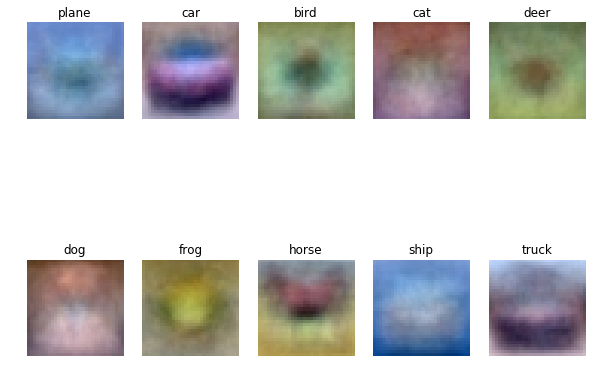

In [28]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])